In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import random
import plotly.express as px
import time
import seaborn as sns
sns.set_theme('talk', palette=sns.color_palette('Set2'))
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## train data load

In [2]:
infile = open('..//4_data_preparation_for_training//X_train','rb')
X_train = pkl.load(infile)
infile.close()

infile = open('..//4_data_preparation_for_training//X_test','rb')
X_test = pkl.load(infile)
infile.close()

infile = open('..//4_data_preparation_for_training//y_train','rb')
y_train = pkl.load(infile)
infile.close()

infile = open('..//4_data_preparation_for_training//y_test','rb')
y_test = pkl.load(infile)
infile.close()

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape, X_test.shape

((25929, 637), (6483, 637))

## creating model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation ,Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [6]:
model = Sequential()

model.add(Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=X_test.shape[1]))
model.add(Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(4, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                20416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)

In [9]:
start = time.time()

model.fit(x=X_train,y=y_train,
          validation_split=0.1,
          batch_size=256,epochs=1000,
#           callbacks=[early_stop],
         )

stop = time.time()
print('\n',round((stop-start)/60,2),'min.')

Train on 23336 samples, validate on 2593 samples
Epoch 1/1000
23336/23336 [==============================] - 1s 28us/sample - loss: 655781753490.5615 - val_loss: 663737861157.5164
Epoch 2/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 655711343865.5934 - val_loss: 663531000324.5415
Epoch 3/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 655071608663.4982 - val_loss: 662158202163.6344
Epoch 4/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 652194972894.9139 - val_loss: 657097560605.8157
Epoch 5/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 643595328853.5674 - val_loss: 643781118260.8191
Epoch 6/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 623772414346.5753 - val_loss: 615822839142.9727
Epoch 7/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 585946062019.5325 - val_loss: 566429380723.3135
Epoch 8/1000
23336/23336 [==============

23336/23336 [==============================] - 0s 7us/sample - loss: 55692982187.0470 - val_loss: 57031726472.1450
Epoch 58/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 55059235652.8927 - val_loss: 56347627363.6159
Epoch 59/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 54453491708.4895 - val_loss: 55665038255.8334
Epoch 60/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 53905161709.2191 - val_loss: 55082574872.8793
Epoch 61/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 53376301146.5698 - val_loss: 54487802725.5904
Epoch 62/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 52878456246.4559 - val_loss: 53947576180.2021
Epoch 63/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 52410605596.0836 - val_loss: 53442320714.9341
Epoch 64/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 51969146343.6023 - val_loss:

23336/23336 [==============================] - 0s 7us/sample - loss: 42240003642.4491 - val_loss: 42822114052.0478
Epoch 121/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 42102221839.7971 - val_loss: 42631358881.8141
Epoch 122/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 41973032832.2194 - val_loss: 42482541611.8349
Epoch 123/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 41834676781.4604 - val_loss: 42393062314.3047
Epoch 124/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 41699696183.6407 - val_loss: 42245783863.5835
Epoch 125/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 41562857344.9215 - val_loss: 42053254179.9368
Epoch 126/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 41429608497.8485 - val_loss: 41916774901.5349
Epoch 127/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 41294419113.5550 - va

23336/23336 [==============================] - 0s 6us/sample - loss: 35169672200.7761 - val_loss: 35805211271.2565
Epoch 184/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 35088447483.0854 - val_loss: 35739461200.7590
Epoch 185/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 35006348802.2818 - val_loss: 35585913531.3845
Epoch 186/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 34928594350.0309 - val_loss: 35513832694.8184
Epoch 187/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 34829743065.0339 - val_loss: 35403856707.2333
Epoch 188/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 34754546957.9541 - val_loss: 35323819596.0201
Epoch 189/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 34669939218.0788 - val_loss: 35235579689.5642
Epoch 190/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 34586890628.6075 - va

23336/23336 [==============================] - 0s 6us/sample - loss: 31571214469.3973 - val_loss: 32666847368.2437
Epoch 247/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 31534096246.3901 - val_loss: 32647971392.1728
Epoch 248/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 31490936365.8115 - val_loss: 32621770718.0378
Epoch 249/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 31460906390.8618 - val_loss: 32595250381.3529
Epoch 250/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 31424126550.5327 - val_loss: 32568049802.2183
Epoch 251/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 31382284434.7371 - val_loss: 32598256320.5183
Epoch 252/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 31365091569.5194 - val_loss: 32558578565.1832
Epoch 253/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 31316712223.6819 - va

23336/23336 [==============================] - 0s 6us/sample - loss: 29864868888.2221 - val_loss: 31707757259.5758
Epoch 310/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29847683928.5513 - val_loss: 31690616612.4304
Epoch 311/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29816377511.0977 - val_loss: 31707428199.3675
Epoch 312/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29803435556.6843 - val_loss: 31646154647.7439
Epoch 313/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 29779764205.3946 - val_loss: 31646409023.8766
Epoch 314/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29778573150.5190 - val_loss: 31644663098.7428
Epoch 315/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29744763846.0775 - val_loss: 31656672953.8049
Epoch 316/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 29728960721.2232 - va

23336/23336 [==============================] - 0s 9us/sample - loss: 28801324614.3846 - val_loss: 31229776721.0552
Epoch 373/1000
23336/23336 [==============================] - 0s 9us/sample - loss: 28795615244.6376 - val_loss: 31213739701.8558
Epoch 374/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 28769485507.0058 - val_loss: 31218073753.2248
Epoch 375/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 28759726728.7323 - val_loss: 31207959086.4018
Epoch 376/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 28742526329.3740 - val_loss: 31187547214.1921
Epoch 377/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28733229827.5982 - val_loss: 31189888614.8739
Epoch 378/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28723509891.4666 - val_loss: 31184861290.6255
Epoch 379/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28710126685.3781 - va

Epoch 435/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 28088523822.6891 - val_loss: 30898797964.8839
Epoch 436/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28075025670.5821 - val_loss: 30886004074.1319
Epoch 437/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 28064831230.3325 - val_loss: 30876692184.6078
Epoch 438/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 28054353652.5033 - val_loss: 30884989261.6984
Epoch 439/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28045890865.0586 - val_loss: 30880939297.4686
Epoch 440/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28039801269.0518 - val_loss: 30867205619.5604
Epoch 441/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 28026656465.3987 - val_loss: 30873141273.2742
Epoch 442/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 280176

23336/23336 [==============================] - 0s 7us/sample - loss: 27546792538.3942 - val_loss: 30651033069.6367
Epoch 499/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27564149729.4590 - val_loss: 30618062135.9784
Epoch 500/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27544748897.6784 - val_loss: 30643583981.8342
Epoch 501/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27535259112.3044 - val_loss: 30658329784.8176
Epoch 502/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27530710860.2647 - val_loss: 30636038476.9086
Epoch 503/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27516953571.5653 - val_loss: 30642605234.4990
Epoch 504/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27513032767.1882 - val_loss: 30631482933.1153
Epoch 505/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27517473081.8348 - va

23336/23336 [==============================] - 0s 6us/sample - loss: 27137354036.2180 - val_loss: 30354896629.0413
Epoch 562/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27123898127.5338 - val_loss: 30354440592.0432
Epoch 563/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27113535168.5485 - val_loss: 30403223314.6595
Epoch 564/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27118509814.6095 - val_loss: 30364453903.0066
Epoch 565/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 27107888269.1203 - val_loss: 30357727359.9506
Epoch 566/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27109665433.5824 - val_loss: 30339015687.1084
Epoch 567/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27091080663.4542 - val_loss: 30341776659.6467
Epoch 568/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 27099534549.0847 - va

23336/23336 [==============================] - 0s 6us/sample - loss: 26731743314.1447 - val_loss: 30171354550.3494
Epoch 625/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 26720985810.4518 - val_loss: 30180638043.5203
Epoch 626/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26719643696.4443 - val_loss: 30169606142.0255
Epoch 627/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26711018706.2763 - val_loss: 30167966901.6583
Epoch 628/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26703549747.1649 - val_loss: 30168225581.1184
Epoch 629/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26683399252.6020 - val_loss: 30149931124.8932
Epoch 630/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26715728637.6304 - val_loss: 30175977057.7401
Epoch 631/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 26677925060.2345 - va

23336/23336 [==============================] - 0s 9us/sample - loss: 26223270248.1728 - val_loss: 29615264060.7173
Epoch 688/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 26214664424.3922 - val_loss: 29595261092.2823
Epoch 689/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 26205539735.5639 - val_loss: 29582420738.8631
Epoch 690/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 26192040835.5543 - val_loss: 29582595079.8982
Epoch 691/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 26188405837.5811 - val_loss: 29572828187.6437
Epoch 692/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 26181734173.9266 - val_loss: 29554747452.0262
Epoch 693/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 26198261208.8584 - val_loss: 29556158687.1238
Epoch 694/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 26168978488.5183 - va

23336/23336 [==============================] - 0s 7us/sample - loss: 25689260313.1875 - val_loss: 29024306287.7593
Epoch 751/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25683086700.7364 - val_loss: 29005361471.4817
Epoch 752/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25666471455.0675 - val_loss: 29036030010.4466
Epoch 753/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 25651778683.5681 - val_loss: 29018583267.0729
Epoch 754/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25655396799.9342 - val_loss: 28989883264.4443
Epoch 755/1000
23336/23336 [==============================] - 0s 8us/sample - loss: 25640639058.6712 - val_loss: 28973279989.0413
Epoch 756/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25636908249.9993 - val_loss: 28999999131.3968
Epoch 757/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25626683760.5979 - va

23336/23336 [==============================] - 0s 7us/sample - loss: 25201445846.2256 - val_loss: 28528001728.5183
Epoch 814/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25181443957.6880 - val_loss: 28490162880.5183
Epoch 815/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25163368287.9232 - val_loss: 28516520953.6814
Epoch 816/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25154189256.8858 - val_loss: 28477362765.9946
Epoch 817/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25152343314.8687 - val_loss: 28469015456.8268
Epoch 818/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25138636710.1323 - val_loss: 28473318879.0251
Epoch 819/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25143181547.2005 - val_loss: 28442309469.2973
Epoch 820/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 25117761112.2880 - va

23336/23336 [==============================] - 0s 7us/sample - loss: 24694801557.1944 - val_loss: 28040729308.3594
Epoch 877/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24686644568.3757 - val_loss: 28055760441.0644
Epoch 878/1000
23336/23336 [==============================] - 0s 6us/sample - loss: 24679464331.1018 - val_loss: 28017878372.4057
Epoch 879/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24664999487.3637 - val_loss: 28011446403.5048
Epoch 880/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24664166078.4422 - val_loss: 28047464945.5858
Epoch 881/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24646194341.3425 - val_loss: 28019633061.1708
Epoch 882/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24641603148.0014 - val_loss: 27989918312.0586
Epoch 883/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24650050298.4710 - va

23336/23336 [==============================] - 0s 7us/sample - loss: 24212201397.5783 - val_loss: 27464678136.2005
Epoch 940/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24202375861.6661 - val_loss: 27490848703.2349
Epoch 941/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24178776110.3380 - val_loss: 27465042654.7289
Epoch 942/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24165215111.5914 - val_loss: 27487466179.2827
Epoch 943/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24169604171.4748 - val_loss: 27478985057.6413
Epoch 944/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24157307722.5094 - val_loss: 27422779901.6305
Epoch 945/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24145902643.6037 - val_loss: 27430300178.7582
Epoch 946/1000
23336/23336 [==============================] - 0s 7us/sample - loss: 24137582108.9613 - va

In [10]:
losses = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Loss and validation loss')

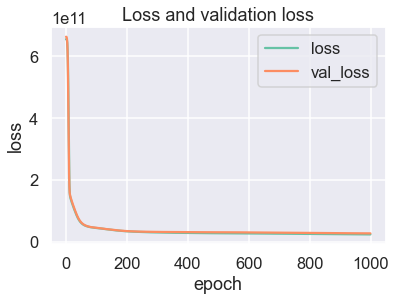

In [11]:
losses.plot()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and validation loss')

(0.0, 100000000000.0)

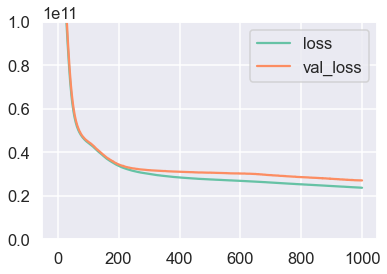

In [12]:
losses.plot()
plt.ylim(0,1e11)

## model evaluation

In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

predictions = model.predict(X_test)
print(f'MAE\t{round(mean_absolute_error(y_test, predictions))}')
print(f'MSE\t{round(np.sqrt(mean_squared_error(y_test, predictions)))}')
print(f'R^2\t{round(r2_score(y_test, predictions),2)}')

MAE	104522
MSE	172838
R^2	0.84


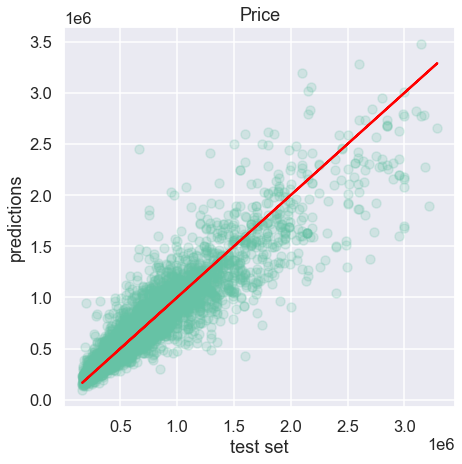

In [14]:
plt.figure(figsize=(7,7))
# plt.xlim(0,500)
# plt.ylim(0,500)

# Predictions
plt.scatter(x=y_test,y=predictions,edgecolor=None,alpha=0.2)
plt.xlabel('test set')
plt.ylabel('predictions')
plt.title('Price')

# Perfect predictions
plt.plot(y_test,y_test,'r')

Text(0.5, 1.0, 'Error distribution')

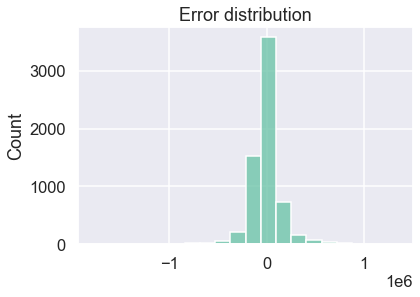

In [15]:
errors = y_test - predictions.reshape(y_test.shape[0])

# plt.xlim(-2e5,2e5)

sns.histplot(errors, bins=20)
plt.title('Error distribution')

Text(0.5, 1.0, 'Errors boxplot')

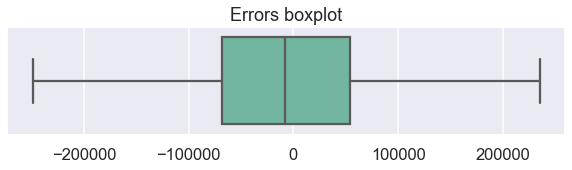

In [16]:
plt.figure(figsize=(10,2))
sns.boxplot(x=errors, showfliers=False)
plt.title('Errors boxplot')

In [17]:
predictions.reshape(y_test.shape[0])[:20]

array([ 979393.7 ,  392738.75,  637863.2 ,  759477.2 ,  427886.47,
        656938.4 ,  438940.3 ,  369532.53,  351353.56,  367491.75,
       1608716.8 ,  669858.25,  908511.  , 1390518.8 ,  329192.28,
        745600.25,  389878.4 ,  522695.38, 1889215.1 ,  686311.8 ],
      dtype=float32)

In [18]:
y_test[:20]

array([ 899000.,  298000.,  698000.,  614500.,  449000.,  616298.,
        422334.,  330000.,  330000.,  329000., 1395000.,  703600.,
       1014378.,  659000.,  279000.,  849000.,  391936.,  469000.,
       1690000.,  700000.])

In [19]:
predictions.reshape(y_test.shape[0])[:20]/y_test[:20]

array([1.08942568, 1.31791527, 0.91384411, 1.23592707, 0.95297655,
       1.06594273, 1.03932033, 1.11979555, 1.06470777, 1.1169962 ,
       1.15320197, 0.95204413, 0.89563358, 2.11004363, 1.17990065,
       0.87820995, 0.99475018, 1.11448907, 1.11787877, 0.98044545])

## saving data

In [20]:
from datetime import datetime
from tensorflow.keras.models import load_model
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")
model.save('ann_models\\' + 'ann_model_' + timestamp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ann_models\ann_model_2023-11-12--13-21\assets


In [21]:
import joblib
joblib.dump(scaler, 'scaler')

['scaler']